# Twitter Analytics - iPhone X vs. Samsung Galaxy S9.
#### 

## Table of Contents

#### [Data Collection Methodology](#data_collect)

#### [Descriptive Analytics](#sect_1)


#### [Content Analytics](#sect_2)


#### [Network Analytics](#sect_3)

<br>
<br>


In [94]:
import tweepy
import csv
import time
import json
import pandas as pd
import re
import numpy as np

from collections import Counter
from operator import itemgetter
from itertools import combinations

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from pandas.io.json import json_normalize
import ast

# Import TextBlob for sentiment analysis
from textblob import TextBlob
from textblob import Word

from IPython.display import HTML, display, Image

In [95]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 250
pd.options.display.float_format = '{:,.4f}'.format

#### Language Codes List

In [96]:
#Language Codes Lookup List
#pip install datapackage
from datapackage import Package

#package = Package('https://datahub.io/core/language-codes/datapackage.json')
#I loaded datapackage.json locally
package = Package('data/datapackage.json')

# print list of all resources if needed:
#print(package.resource_names)

#Get language codes
res=package.get_resource('language-codes')
#res=package.get_resource('language-codes-full')
langlists=res.table.read()

# Use dict comprehension to allow lookup of language by code
lang_codes={d[0]: d[1] for d in langlists}

#Add some old non-standard codes
lang_codes.update({'und': 'Undetermined','in': 'Indonesian','iw': 'Hebrew'})

#### Now we can lookup actual language name by its code found in tweet metadata

In [97]:
# Test language code lookup
lang_codes['sv']

u'Swedish'


### Read Raw Tweets

In [98]:
import json

filename='data/IPhoneXSamsungS9.json'


with open(filename, 'r') as f:
    line = f.readline() # read only the first tweet/line
    tweet = json.loads(line) # load it as Python dictionary
    print(json.dumps(tweet, indent=4)) 
    
# the original data from Twitter looks like below.
f.close()

{
    "quote_count": 0, 
    "contributors": null, 
    "truncated": false, 
    "text": "Todos querr\u00e1n saber el secreto detr\u00e1s de tus fotos. #GalaxyS9 https://t.co/uAHpiVRIF8", 
    "is_quote_status": false, 
    "in_reply_to_status_id": null, 
    "reply_count": 0, 
    "id": 987783049868955654, 
    "favorite_count": 0, 
    "entities": {
        "user_mentions": [], 
        "symbols": [], 
        "hashtags": [
            {
                "indices": [
                    52, 
                    61
                ], 
                "text": "GalaxyS9"
            }
        ], 
        "urls": [], 
        "media": [
            {
                "additional_media_info": {
                    "monetizable": false
                }, 
                "expanded_url": "https://twitter.com/samsungmobilemx/status/987783049868955654/video/1", 
                "display_url": "pic.twitter.com/uAHpiVRIF8", 
                "url": "https://t.co/uAHpiVRIF8", 
                "medi

#### Read file and separate by iPhone X, Samsung S9, or both.

In [99]:
count_samsungs9=0
count_iphonex=0
count_both=0
tweets_both = []
tweets_samsungs9 = []
tweets_iphone = []

with open(filename, 'r') as f:
    for line in f:
        if ( ('galaxys9' in line.lower())|('samsungs9' in line.lower()) | ('galaxy s9' in line.lower())|
            ('samsung s9' in line.lower())  ) & (('iphone x' in line.lower())|('iphonex' in line.lower()) ):
            count_both = count_both+1
            try:
                # List of tweets with both iPhone X and Samsung S9
                tweets_both.append(json.loads(line))
            except:
                pass
        elif ( ('galaxys9' in line.lower())|('samsungs9' in line.lower()) | ('galaxy s9' in line.lower())|
            ('samsung s9' in line.lower())  ):
            count_samsungs9 = count_samsungs9+1
            try:
                # List of tweets with Samsung S9
                tweets_samsungs9.append(json.loads(line))
            except:
                pass
        elif (('iphone x' in line.lower())|('iphonex' in line.lower()) ) :
            count_iphonex = count_iphonex+1
            try:
                # List of tweets with iPhone X
                tweets_iphone.append(json.loads(line))
            except:
                pass
            
    f.close()
print "%s tweets loaded related to both iPhoneX and Samsung S9" %(count_both)
print "%s tweets loaded related to Samsung S9" %(count_samsungs9)
print "%s tweets loaded related to iPhoneX" %(count_iphonex)



701 tweets loaded related to both iPhoneX and Samsung S9
8168 tweets loaded related to Samsung S9
26458 tweets loaded related to iPhoneX


#### Get languages for tweets

In [100]:
lang_both=[]
lang_iphone=[]
lang_samsungs9=[]

for tweet in tweets_both:
    #print tweet['lang']
    lang_both.append(tweet['lang'])
    
for tweet in tweets_iphone:
    #print tweet['lang']
    lang_iphone.append(tweet['lang'])

for tweet in tweets_samsungs9:
#    #print tweet['lang']
    lang_samsungs9.append(tweet['lang'])


#### Language frequency counts

In [101]:

#Count frequency of languages for tweets with both iPhone X and Samsung S9
count_lang_both = Counter(lang_both)
#print count_lang_both

#Count frequency of languages for tweets with iPhone X
count_lang_iphone = Counter(lang_iphone)
#print count_lang_iphone

#Count frequency of languages for tweets with Samsung S9
count_lang_samsungs9 = Counter(lang_samsungs9)
#print count_lang_samsungs9



In [102]:
#Language counts for Tweets with both iPhone X and Samsung S9
count_lang_both.items()
df_count_lang_both = pd.DataFrame(count_lang_both.items())
df_count_lang_both.rename(columns = {0: 'Language Code',1:'Number Tweets'},inplace=True)
df_count_lang_both['Language Name']=df_count_lang_both['Language Code'].apply(lambda x: lang_codes[x] )
print "Number of languages in tweets containing both iPhone X and Samsung S9: %s" % len(df_count_lang_both)
df_count_lang_both.sort_values(by='Number Tweets', ascending=False)

Number of languages in tweets containing both iPhone X and Samsung S9: 18


,Language Code,Number Tweets,Language Name
2,en,462,English
13,in,69,Indonesian
17,es,59,Spanish; Castilian
16,ja,31,Japanese
5,de,16,German
12,th,13,Thai
3,pt,11,Portuguese
1,fr,8,French
11,und,7,Undetermined
0,ru,7,Russian


In [103]:
#Language counts for Tweets with iPhone X
count_lang_iphone.items()
df_count_lang_iphone = pd.DataFrame(count_lang_iphone.items())
df_count_lang_iphone.rename(columns = {0: 'Language Code',1:'Number Tweets'},inplace=True)
df_count_lang_iphone['Language Name']=df_count_lang_iphone['Language Code'].apply(lambda x: lang_codes[x] )
print "Number of languages in tweets containing iPhone X: %s" % len(df_count_lang_iphone)
df_count_lang_iphone.sort_values(by='Number Tweets', ascending=False)


Number of languages in tweets containing iPhone X: 49


,Language Code,Number Tweets,Language Name
1,en,12712,English
38,ja,5126,Japanese
22,tl,1796,Tagalog
17,pt,1619,Portuguese
14,es,1290,Spanish; Castilian
11,in,772,Indonesian
24,th,627,Thai
27,fr,512,French
30,de,380,German
44,und,320,Undetermined


In [104]:
#Language counts for Tweets with Samsung S9
df_count_lang_samsungs9 = pd.DataFrame(count_lang_samsungs9.items())
df_count_lang_samsungs9.rename(columns = {0: 'Language Code',1:'Number Tweets'},inplace=True)
df_count_lang_samsungs9['Language Name']=df_count_lang_samsungs9['Language Code'].apply(lambda x: lang_codes[x] )
print "Number of languages in tweets containing Samsung S9: %s" % len(df_count_lang_samsungs9)
df_count_lang_samsungs9.sort_values(by='Number Tweets', ascending=False)


Number of languages in tweets containing Samsung S9: 40


,Language Code,Number Tweets,Language Name
1,en,3663,English
15,pt,1470,Portuguese
25,fr,931,French
12,es,864,Spanish; Castilian
37,und,229,Undetermined
9,in,159,Indonesian
27,de,138,German
4,ca,104,Catalan; Valencian
34,ja,76,Japanese
8,ar,74,Arabic


# iPhone Descriptive Analytics

### Tweet Metrics:
* Total Number of Tweets
* Total Number of Unique Users
* 10 Most Common Users
* Number of Orignal Tweets vs ReTweets


In [105]:
#Number of Tweets
print 'Total Number of iPhone Tweets: ' + str(len(tweets_iphone))

Total Number of iPhone Tweets: 26458


In [106]:
#Number of Uniquer Users
from collections import Counter

iphone_screen_names = [T['user']['screen_name'] for T in tweets_iphone]

iphone_users = Counter(iphone_screen_names)

print 'Print Number of unique users: ' + str(len(iphone_users))

Print Number of unique users: 21541


In [107]:
# top 10 most active tweeters
iphone_users.most_common(10)

[(u'JustMrLoloN', 70),
 (u'PPP_isesaki', 54),
 (u'nanoed', 50),
 (u'iPhone8andx', 50),
 (u'perfect_cart', 45),
 (u'Vgadgetshow', 41),
 (u'Jonathanamorcit', 31),
 (u'smanavi_info', 31),
 (u'Minashopp_', 28),
 (u'Petrichorcases', 27)]

In [108]:
#orginal vs retweets 
iphone_originaltweets = []
iphone_original_tweet_count = 0
iphone_retweet_tweet_count = 0

for tweet in tweets_iphone:
    if 'rt @' not in tweet['text'].lower():
        iphone_originaltweets.append(tweet)
        iphone_original_tweet_count +=1
    else:
        iphone_retweet_tweet_count+=1
        
print "Number of original tweets: "+ str(iphone_original_tweet_count)
print "Number of retweets: "+ str(iphone_retweet_tweet_count)

Number of original tweets: 10521
Number of retweets: 15937


In [109]:
# of mentions
iphone_user_mentions = []


for tweet in tweets_iphone:
    for mention in tweet['entities']['user_mentions']:
        iphone_user_mentions.append(mention)

        
print 'Number of Mentions: ' + str(len(iphone_user_mentions))

Number of Mentions: 22516


### User Metrics
* Number of User Mentions
* Top 10 Most User's Mentioned

In [110]:
#top 10m most common user mentions

iphone_user_mentions_df = pd.DataFrame(iphone_user_mentions)
print 'Most Popular User Mentions:'
iphone_user_mentions_df['screen_name'].value_counts().head(10)

Most Popular User Mentions:


GiveawayPluss    2404
giveawaycntrl    1767
BelleLife_gc     1521
IzwanHs          1149
lorynegracex     1107
_mominz          1004
YouTube           407
kalluxrz          384
inesds_c          380
GladysSeara       357
Name: screen_name, dtype: int64

### URL Metrics:
* Most Common URLs in English Tweets

In [111]:
#most common URLs in english tweets
iphone_urls = []

for tweet in tweets_iphone:
    if tweet['lang'] == 'en':
        for url in tweet['entities']['urls']:
             iphone_urls.append(url)

iphone_urls_df = pd.DataFrame(iphone_urls)

print 'Most Popular URLs Hashtags:'
iphone_urls_df['url'].value_counts().head(10)

Most Popular URLs Hashtags:


https://t.co/Zswf2VzzCy    293
https://t.co/XzdSESqEPM    239
https://t.co/tjcD8nfABU    195
https://t.co/4M6JaY9Mrm     84
https://t.co/kNziLZtbcX     39
https://t.co/mESHuWv1Yl     32
https://t.co/MV6iAXX2lk     27
https://t.co/XNY3hOH7Fr     26
https://t.co/NoBemYWJ7o     26
https://t.co/wRU7GbViGp     22
Name: url, dtype: int64

# iPhone Content Analytics using English Tweets

In [112]:
# import packages for text processing
import csv
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#import pyLDAvis.gensim

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)  # To ignore all warnings that arise here to enhance clarity

In [113]:
#gather list of text of english tweets:
iphone_english_tweet_text = []

for i in tweets_iphone:
    if i['user']['lang'] == "en":
        iphone_english_tweet_text.append(i['text'])
#print "Total number of english tweets: " + str(len(iphone_english_tweet_text))

In [152]:
#Text Cleaning

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
iphone_tokens = []

#convert lists to strings
iphone_english_tweet_text_str = str(iphone_english_tweet_text)

#lowercase
iphone_tokens = iphone_english_tweet_text_str.lower()

#tokenize
iphone_tokens = iphone_tokens.split()

#Remove stopwords
iphone_more_stopwords = set(('iphonex', 'iphone x','dont','want','like'))
iphone_stoplist = set(stopwords.words('english')) | iphone_more_stopwords
iphone_tokens = (word for word in iphone_tokens if word not in iphone_stoplist)


# Filter non-alphanumeric chars from tokens
iphone_tokens = (ch.lower() for ch in iphone_tokens if ch.isalpha())

#remove short words
iphone_tokens = (word for word in iphone_tokens if len(word) >= 4)

#put into a string for wordcloud
str_iphone_tokens = ''
for i in iphone_tokens:
    #print i
    str_iphone_tokens = str_iphone_tokens + str(i) +', '


### Word Analysis
* Term/Word Frequency

In [142]:
#compute word frequency distribution
iphone_fdist = nltk.FreqDist(iphone_tokens)

In [143]:
#print 50 most commond terms
iphone_fdist.most_common(50)

[('iphone', 11030),
 ('giveaway', 3579),
 ('post', 2129),
 ('notification', 1736),
 ('lang', 1187),
 ('para', 1164),
 ('tiwala', 1150),
 ('huawei', 1145),
 ('lucky', 1099),
 ('magkaiphone', 1093),
 ('mode', 1078),
 ('light', 1075),
 ('morning', 1066),
 ('dark', 1061),
 ('areas', 1059),
 ('shots', 1059),
 ('apply', 1059),
 ('direct', 1057),
 ('winners', 837),
 ('retweet', 622),
 ('phone', 617),
 ('follow', 548),
 ('apple', 533),
 ('first', 455),
 ('plus', 422),
 ('case', 410),
 ('brand', 388),
 ('mass', 317),
 ('rakan', 304),
 ('proof', 285),
 ('yung', 261),
 ('pera', 251),
 ('join', 248),
 ('kaya', 243),
 ('chance', 240),
 ('winner', 239),
 ('mean', 237),
 ('napadami', 233),
 ('siguro', 233),
 ('naging', 233),
 ('please', 216),
 ('today', 215),
 ('announcing', 205),
 ('picking', 204),
 ('enter', 202),
 ('better', 199),
 ('video', 193),
 ('stop', 192),
 ('free', 184),
 ('lost', 183)]

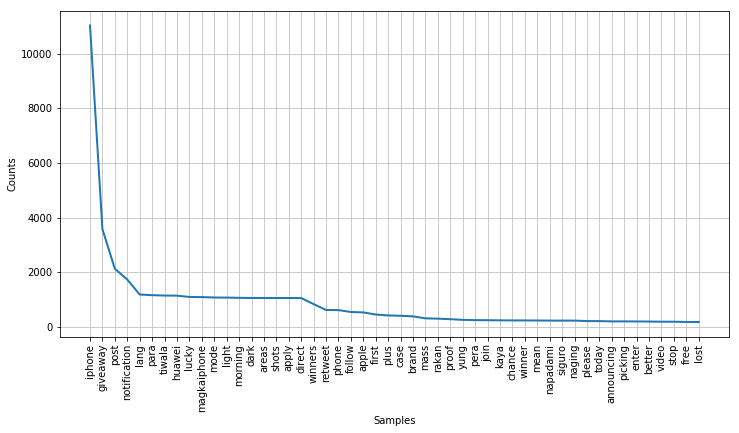

In [144]:
# graph of 50 most common words
plt.figure(figsize=(12,6))
iphone_fdist.plot(50)

### WordCloud for terms

(-0.5, 399.5, 199.5, -0.5)

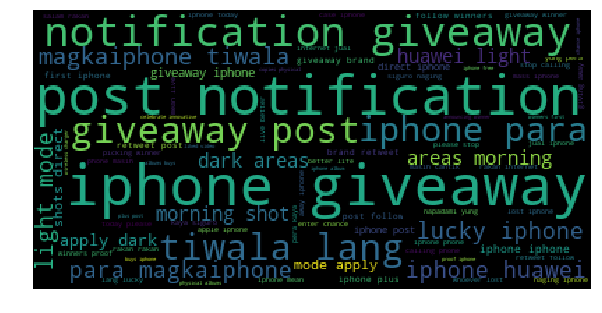

In [161]:
#present word cloud

from os import path
from PIL import Image
from wordcloud import WordCloud


# Generate a word cloud image
wordcloud = WordCloud().generate(str_iphone_tokens)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")

### Hashtag Analysis
* Top 10 Most popular hashtags in English Tweets

In [58]:
#most common hash tags using english tweets
iphone_hashtags = []

for tweet in tweets_iphone:
    if tweet['lang'] == 'en':
        for hashtag in tweet['entities']['hashtags']:
             iphone_hashtags.append(hashtag)


iphone_hashtags_df = pd.DataFrame(iphone_hashtags)
#remove iPhoneX and iphonex hashtags
iphone_hashtags_df = iphone_hashtags_df[iphone_hashtags_df.text != 'iPhoneX']
iphone_hashtags_df = iphone_hashtags_df[iphone_hashtags_df.text != 'iphonex']
print 'Most Popular English Hashtags:'
iphone_hashtags_df['text'].value_counts().head(10)

Most Popular English Hashtags:


JBJจังหวะซิทคอม     1005
iPhone8              476
iPhone8Plus          389
iPhone               233
giveaway             109
obiwezyisyourguy      98
Telegram              87
wallpaper             85
iphone                80
wallpapers            78
Name: text, dtype: int64

### iPhone Topic Modeling
* Compute optimal number of topics
* Build Model and view Topics

In [59]:
import pandas as pd

# import packages for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

from gensim.corpora import Dictionary
from gensim.models import ldamodel
import numpy
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)  # To ignore all warnings that arise here to enhance clarity

In [60]:
#Cleaning the list for topic modeling. 

tweet_token_listA = []
tweet_token_listB = []

#loop through the tweets and clean the text of the tweet for topic modeling
for tweet in iphone_english_tweet_text:
    tweet_token_listA = [] #reset
    
    #lowercase
    tweet = tweet.lower()
    
    # Remove useless numbers and alphanumerical words
    tweet = re.sub("[^a-zA-Z0-9]", " ", tweet)
    
    #tokenize
    tweet_tokens = tweet.split()
    
    #remove stopwords
    tweet_tokens = (word for word in tweet_tokens if word not in iphone_stoplist)
    
    # Filter non-alphanumeric characters from auto_tokens
    tweet_tokens = (word for word in tweet_tokens if word.isalpha())
    
    #remove short words
    tweet_tokens = (word for word in tweet_tokens if len(word) >= 4)
    
    
    for i in tweet_tokens:
        #remove @ mentions, url links and hashtags
        if (not i.startswith( '@' )) and (not i.startswith( 'http' )) and (not i.startswith( '#' )):
            tweet_token_listA.append(str(i))
        
    #add the tweet to the list, don't add blank lines
    if len(tweet_token_listA) >2:
        tweet_token_listB.append(tweet_token_listA)


In [61]:
# this is text processing required for topic modeling with Gensim
iphone_dictionary = Dictionary(tweet_token_listB)
iphone_corpus = [iphone_dictionary.doc2bow(text) for text in tweet_token_listB]

In [31]:
#save the dictionary & corpus
iphone_dictionary.save('data/iphone.dict')  # store the dictionary, for future reference
corpora.MmCorpus.serialize('data/iphone.mm', iphone_corpus)  # store to disk, for later use  # store to disk, for later use

In [87]:
#find optimal k value
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

#use a range of 2-10 topics
for k in range(2,10):
    goodLdaModel = ldamodel.LdaModel(corpus=iphone_corpus, id2word=iphone_dictionary, num_topics=k, passes=50)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=iphone_corpus, dictionary=iphone_dictionary, coherence='u_mass')
    print goodcm.get_coherence()

-14.3157028459
-13.0461571844
-14.3020796215
-14.102725721
-14.5237807507
-14.7025550223
-14.2480437004
-15.3416097518


#### Optimal number of topics is 3.

In [63]:
#Create LDA Topic Model for 3 topics
iphone_ldamodel = ldamodel.LdaModel(iphone_corpus, id2word=iphone_dictionary, num_topics=3, passes=20)

In [64]:
#list model topics
iphone_ldamodel.show_topics()

[(0,
  u'0.067*"iphone" + 0.064*"light" + 0.038*"cross" + 0.036*"please" + 0.035*"huawei" + 0.034*"izwanhs" + 0.032*"mode" + 0.032*"morning" + 0.032*"shots" + 0.032*"category"'),
 (1,
  u'0.105*"iphone" + 0.021*"apple" + 0.010*"case" + 0.008*"plus" + 0.007*"winner" + 0.006*"phone" + 0.005*"video" + 0.005*"samsung" + 0.005*"free" + 0.004*"yung"'),
 (2,
  u'0.120*"giveaway" + 0.097*"iphone" + 0.069*"follow" + 0.056*"post" + 0.054*"giveawaypluss" + 0.049*"fast" + 0.048*"turn" + 0.047*"notification" + 0.039*"giveawaycntrl" + 0.024*"winners"')]

1. Topic appears to be about life and living, more social things.
2. Topic appears to be about photography
3. Topic appears to be about prizes and a giveaway competition.

### iPhone Sentiment Analysis
using Pattern lexicon

* Compute number of positive, negative and neutral tweets
* Show Text of most positve and negative tweets

In [65]:
#patten lexicon
from pattern.en import sentiment

#totals
intPositiveTotal = 0
intNegativeTotal = 0
intNeutralTotal = 0

#highest/lowest
highestscore =0
lowestscore = 0
most_positive_tweet =''
most_negative_tweet =''

for row in tweet_token_listB:
    score = sentiment(row)
    #print score[0], score[1]  
    
    #totals
    if score[0] >= 0.15:
        intPositiveTotal += 1
        if score[0] > highestscore:
            highestscore = score[0]
            most_positive_tweet = row
    elif score[0] < 0.15 and score[0] >= -0.1499:
        intNeutralTotal += 1
    else:
        intNegativeTotal += 1
        if score[0] < lowestscore:
            lowestscore= score[0]
            most_negative_tweet = row
    
    

In [66]:
#Totals
print "Using Patten Lexicon:"
print "There are " + str(intPositiveTotal) +" Positive Tweets."
print "There are " + str(intNegativeTotal) +" Negative Tweets."
print "There are " + str(intNeutralTotal) +" Neutral Tweets."
print ''
print 'Most Positive Tweet Tokens: ' + str(most_positive_tweet)
print 'Most Negative Tweet Tokens: ' + str(most_negative_tweet)

Using Patten Lexicon:
There are 6430 Positive Tweets.
There are 719 Negative Tweets.
There are 6540 Neutral Tweets.

Most Positive Tweet Tokens: ['craving', 'football', 'looking', 'awesome', 'wallpaper', 'phone', 'worry', 'covere']
Most Negative Tweet Tokens: ['apple', 'iphone', 'horrible', 'swipe', 'apps', 'instead', 'touch']


# iphone network analysis

* Create a user mention network from the tweet data and analyize it in Gephi

In [84]:
#collect user mentions into a list.
list_iphone_user_mentions =[]
list_iphone_user_mentions_individual =[]

for tweet in tweets_iphone:
    
    #capture a list of users and their mentions
    for user_mention in tweet['entities']['user_mentions']:
        list_iphone_user_mentions_individual =[] # reset
        list_iphone_user_mentions_individual.append(tweet['user']['screen_name'])
        list_iphone_user_mentions_individual.append(user_mention['screen_name'])
        
        list_iphone_user_mentions.append(list_iphone_user_mentions_individual)

In [79]:
#move the list to a dataframe and save as CSV for analysis in Gephi.
df_iphone_user_mentions = pd.DataFrame(list_iphone_user_mentions)
df_iphone_user_mentions.to_csv("data/iphone_usermentions.csv",index=False, header=False)    

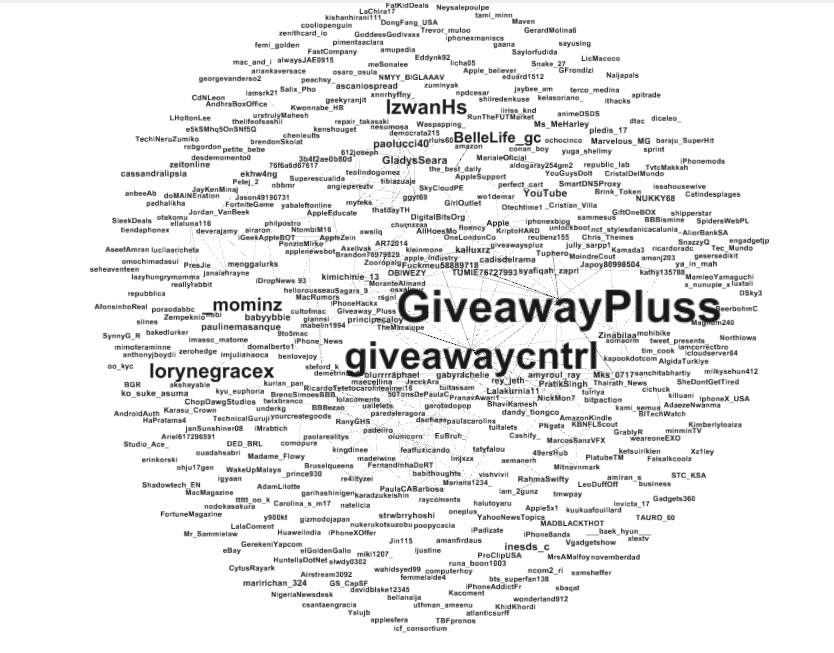

In [86]:
#Gephi Graph
from IPython.display import Image
Image("network_analysis/iphone_mention_network.png")

This is a Fruchterman Reingold layout format of the user mention iPhone data.  The text name size is scaled on the Eisenvector Centrality.  There appears to have been a contest for free phones, this is the reason the users <b>GiveawayPluss</b> and <b>giveawaycntrl</b> are popular.  Other users are tweeting at them to win the contest.

Other popular users post a lot about photography users such as <b>IzwanHz</b> and others are popular in other languages making it difficult to determine thier exact purpose.

There were over 2100 classes, so the overall modularity was 0.936, which given such a broad topic is not unexpected. Similarly the graph density was 0.004 which is very sparce and expected.


